## Supervised Learning

The goal of this project is to get experience with supervised classification algorithms <br>
and multilayer feed forward neural networks. <br>
The datasets will be synthetic and I will implement the methods without the use of ML libraries.

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
from collections import Counter

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes.
Since this data set is synthetic it is not necessary to shuffle it since that is already done by scikit, but it would be useful to shuffle it if it was real world data with no other obvious way to split it.

We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *will not be used* till the end of the project.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [2]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [3]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [4]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [5]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

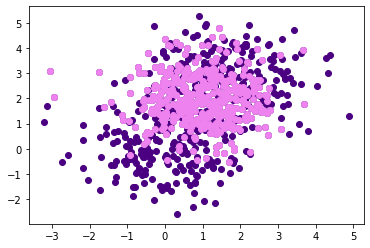

In [6]:
# Your solution
plt.scatter(*zip(*X_train), c="indigo")
plt.scatter(*zip(*X_train[t2_train.astype("bool")]), c="violet")

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression.

We will train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*.

In [7]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self, X_testing, y_test, **kwargs):
        pred = self.predict(X_testing, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)
    
def add_bias(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    sh = X.shape
    m = sh[0]
    bias = np.ones((m,1)) # Make a m*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis = 1) 

class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        for e in range(epochs):
            change = eta / k *  X_train.T @ (X_train @ weights - t_train)     
            weights -= change
            
            if sum(abs(weights)) < diff:
                break
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold    

thresholds = [0.000000000001, 0.1, 0.2, 0.3]

for x in thresholds:
    cls = NumpyLinRegClass()
    cls.fit(X_train, t2_train, epochs=10000, diff=x)
    print(cls.accuracy(X_val, t2_val))


0.6075
0.6075
0.6075
0.445


0.2 seems like a reasonable value for diff

### Logistic regression
Now we do the same thing with logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [8]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)

def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyMultiLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data
        
        Makes a fit for each feature, t_train now has multiple values"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        for e in range(epochs):
            change = eta / k *  X_train.T @ (self.forward(X_train) - t_train)
            weights -= change
            
            if sum(abs(change)) < diff:
                break
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')
    
thresholds = [1e-09, 0.001, 0.004, 0.01, 0.1]

for x in thresholds:
    cls = NumpyMultiLogReg()
    cls.fit(X_train, t_train, epochs=1000, diff=x)
    print(cls.accuracy(X_val, t_val))

0.59
0.59
0.59
0.59
0.59


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier.

We train on (X_train, t2_train) and test on (X2_val, t2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [9]:
def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PyClassifier():
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self, X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)

# testing
for k in [3,19,20,21,25, 30, 100]:
    cls = PykNNClassifier(k)
    cls.fit(list(X_train), list(t2_train))
    print(cls.accuracy(list(X_val), list(t2_val)))

0.68
0.7525
0.7625
0.7575
0.7525
0.75
0.745


k=20 seems to do the best job

### Simple perceptron
Finally, we run a simple perceptron on the same set, and report and store accuracy.

In [10]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        X_train = [[1]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0.

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] -= eta * (y - t) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

# testing
cls = PyPerClassifier()
cls.fit(list(X_train), list(t2_train))
print(cls.accuracy(list(X_val), list(t2_val)))

0.6475


### Summary
Here are the accuracies for the four classifiers in a table.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax">Name</th>
    <th class="tg-0lax">Accuracy</th>
    <th class="tg-0lax">Parameters</th>
    <th class="tg-0lax">Comments</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Linear regression</td>
    <td class="tg-0pky">0.6075</td>
    <td class="tg-0pky">diff = 0.2</td>
    <td class="tg-0lax">No difference as long as diff &lt; 0.2</td>
  </tr>
  <tr>
    <td class="tg-0pky">Logisitic regression</td>
    <td class="tg-0pky">0.64</td>
    <td class="tg-0pky">diff = 0.004</td>
    <td class="tg-0lax">This was worse for both higher and lower values of diff</td>
  </tr>
  <tr>
    <td class="tg-0pky">kNN</td>
    <td class="tg-0pky">0.7625</td>
    <td class="tg-0pky">k = 20</td>
    <td class="tg-0lax">This was also worse for both more and fewer neighbours</td>
  </tr>
  <tr>
    <td class="tg-0pky">Perceptron</td>
    <td class="tg-0pky">0.745</td>
    <td class="tg-0pky"></td>
    <td class="tg-0lax">This was fairly quick, as expected, but I hoped it would beat kNN</td>
  </tr>
</tbody>
</table>

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
The *k*-nearest neighbors classifier can also handle multiple classes without needing to be modified. We will train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*.

In [11]:
for k in [3,19,20,21,25, 30, 100]:
    cls = PykNNClassifier(k)
    cls.fit(list(X_train), list(t_train))
    print(cls.accuracy(list(X_val), list(t_val)))
    
# again it seems like k=20 is the better option

0.675
0.755
0.7675
0.76
0.7525
0.755
0.7475


### Logistic regression "one-vs-rest"
A logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

We will also extend the logisitc regression classifier to a multi-class classifier.

In [12]:
# for every feature
# define one-vs-rest
# fit training data and predict

for num in range(3):
    t3_train = (t_train == num).astype("int")

class NumpyMultiLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        
        # Fits a training set for each feature
        self.features = set(t_train)
        t_list_features = []
        (k, m) = X_train.shape
        self.weights = np.zeros((len(self.features), m+1))
        X_train = add_bias(X_train)
        
        for f in self.features:
            t_feature = (t_train == f).astype("int")
            t_list_features.append(t_feature)
            
            self.weights[f] = weights = np.zeros(m+1)
            
            for e in range(epochs):
                change = eta / k *  X_train.T @ (self.forward(X_train, f) - t_list_features[f])
                weights -= change
            
                if sum(abs(change)) < diff:
                    break
    
    def forward(self, X, f):
        return logistic(X @ self.weights[f])
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = []
        predicted = np.zeros(len(x))
        # check the probability for each feature
        for f in self.features:
            score.append(self.forward(z,f))
        # decide which feature the point is the closest to
        for i in range(len(x)):
            best = 0
            # find the highest probability
            for f in self.features:
                if score[f][i] > best:
                    best = score[f][i]
                    # assign that feature as the predicted for the chosen point
                    predicted[i] = f
        return predicted

cls = NumpyMultiLogReg()
cls.fit(X_train, t_train)
cls.accuracy(X_val, t_val)

0.285

Some observations so far:
* The kNN does better than the one-vs-rest approach to logistic classification above
* The three-class classifier does worse than the binary one, I expected it to score above 1/3
* I would assume one of the reasons is that the three-class classifier will be penalized more as there are more possibilities for false classifications, e.g. if a point which was feature 2 was classifed as feature 0 the three-class classifier is wrong to classify it as such, whereas the binary classifier can be right by just classifying it as "not feature 0". 


## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). <br>
As we see, some of the classifiers are not doing too well on the (X, t2) set. <br>
It is easy to see from the plot that this data set is not well suited for linear classifiers.<br>
There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. <br>
This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). We will try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now.
(Some of the classifiers could probably achieve better results if we scaled the data).

### Linear regression with non-linear features

In [13]:
def add_bias(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    sh = X.shape
    m = sh[0]
    bias = np.ones((m,1)) # Make a m*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis = 1)

def add_non_linear_features(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+3) matrix with three added linear features in position m+1,m+2,m+3
    these will be x_1^2, x_2^2 and x_1*x_2 all consecutive x_i's will be unused, 
    it is assumed that X already has x_0 as a bias weight"""
    sh = X.shape
    m = sh[0]
    # We are adding 3 linear features to all m rows
    non_linear_features = np.zeros((m,3))
    for i in range(m):
        non_linear_features[i][0] = X[i][1]**2
        non_linear_features[i][1] = X[i][2]**2
        non_linear_features[i][2] = X[i][1]*X[i][2]
    return np.concatenate((X, non_linear_features), axis = 1)
    

class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        X_train = add_non_linear_features(add_bias(X_train))
        (m, n) = X_train.shape
        self.weights = weights = np.zeros(n)
        
        for e in range(epochs):
            change = eta / k *  X_train.T @ (X_train @ weights - t_train)     
            weights -= change
            
            if sum(abs(weights)) < diff:
                break
    
    def predict(self, x, threshold=0.5):
        z = add_non_linear_features(add_bias(x))
        score = z @ self.weights
        return score>threshold    

thresholds = [1e-9, 0.1, 0.2, 0.3]
add_non_linear_features(add_bias(X_train))
for x in thresholds:
    cls = NumpyLinRegClass()
    cls.fit(X_train, t2_train, epochs=1000, diff=x)
    print(cls.accuracy(X_val, t2_val))



0.5275
0.5275
0.5275
0.5275


/tmp/ipykernel_45479/736322123.py:37: RuntimeWarning: overflow encountered in matmul
  change = eta / k *  X_train.T @ (X_train @ weights - t_train)
/tmp/ipykernel_45479/736322123.py:37: RuntimeWarning: invalid value encountered in matmul
  change = eta / k *  X_train.T @ (X_train @ weights - t_train)
/tmp/ipykernel_45479/736322123.py:46: RuntimeWarning: invalid value encountered in greater
  return score>threshold


### Logistic regression with linear features

In [14]:
class NumpyMultiLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data
        
        Makes a fit for each feature, t_train now has multiple values"""
        
        X_train = add_non_linear_features(add_bias(X_train))
        (m, n) = X_train.shape
        
        self.weights = weights = np.zeros(n)
        
        for e in range(epochs):
            change = eta / k *  X_train.T @ (self.forward(X_train) - t_train)
            weights -= change
            
            if sum(abs(change)) < diff:
                break
    
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_non_linear_features(add_bias(x))
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_non_linear_features(add_bias(x))
        score = self.forward(z)
        return (score>threshold).astype('int')
    
thresholds = [1e-09, 0.001, 0.004, 0.01, 0.1]

for x in thresholds:
    cls = NumpyMultiLogReg()
    cls.fit(X_train, t_train, epochs=1000, diff=x)
    print(cls.accuracy(X_val, t_val))

0.48
0.48
0.48
0.48
0.48


### Perceptron with non linear features

In [15]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        # adding the non linear features
        X_train = add_non_linear_features(add_bias(np.array(X_train)))
        X_train = [list(x) for x in X_train] # Put bias in position 0
    
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0.

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] -= eta * (y - t) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        # adding the non linear features for each predicted x
        x = [1] + list(x) + [x[0]**2] + [x[1]**2] + [x[0]*x[1]]
        score = self.forward(x)
        return int(score > 0)

# testing
cls = PyPerClassifier()
cls.fit(list(X_train), list(t2_train))
print(cls.accuracy(list(X_val), list(t2_val)))

0.61


The kNN already uses non linear features so we will skip this one

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky">Classifier</th>
    <th class="tg-0pky">Linear regression</th>
    <th class="tg-0pky">Logistic regression</th>
    <th class="tg-0pky">Perceptron</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Without linear features</td>
    <td class="tg-0pky">0.6075</td>
    <td class="tg-0pky">0.59</td>
    <td class="tg-0pky">0.6475</td>
  </tr>
  <tr>
    <td class="tg-0lax">With linear features</td>
    <td class="tg-0lax">0.5275</td>
    <td class="tg-0lax">0.48</td>
    <td class="tg-0lax">0.61</td>
  </tr>
</tbody>
</table>

In general the classifiers perform worse with the non linear features, but the perceptron is the one that is the least affected with its accuracy only being reduced by 3.75 percentage points and the logistic regression is the most affected, being reduced by 11 percentage points

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all we should scale the X, here I use a min-max scaler.

In [16]:
# using a min-max scaler

x_max = np.max(X_train)
x_min = np.min(X_train)
X_scaled = (X_train - x_min)/(x_max - x_min)

## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [17]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances. Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*.

In [18]:

# amount of features
dim_in =  X_train.shape[1]  # Calculate the correct value from the input data

dim_out = len(set(t_train))

# convert t_train to one-hot-encoding
hot_map = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
t_hot = [hot_map[x] for x in t_train]

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. We will create the weight matrices and initialize them to small random numbers. Augmenting the dimension by one to get the correct dimensions with the bias terms.

In [19]:
# add +1 for the bias
weights1 = np.zeros((dim_in+1, dim_hidden))
weights2 = np.zeros((dim_hidden+1, dim_out))

# setting the bias to 1
weights1[0] = weights2[0] = 1

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will use the logistic (sigmoid) activation function in both layers.

In [20]:
hidden_activations = add_bias(X_scaled) @ weights1

In [21]:
X_temp = add_bias(X_scaled)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def forward(X):
    H_j = X @ weights1
    A = sigmoid(H_j)
    A_b = add_bias(A)
    H_k = A_b @ weights2
    
    return sigmoid(H_k)

output_activations = forward(X_temp)

### Backwards phase
Here we calculate the delta terms at the output. We assume that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [22]:
y_k = forward(add_bias(X_scaled))
delta_o = (y_k - t_hot)*y_k*(1-y_k)

Here we calculate the delta terms in the hidden layer.

In [23]:
def backward(X):
    y_k = forward(X)
    delta_o = (y_k - t_hot)*y_k*(1-y_k)
    H_j = X @ weights1
    A = sigmoid(H_j)
    A = add_bias(A)
    delta_h = A * (1-A) * (delta_o @ weights2.T)
    return delta_h


X_temp = forward(add_bias(X_scaled))
backward(X_temp)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We update the weights and check that they have changed.

In [24]:
#update weights
X_temp = add_bias(X_scaled)
y_k = forward(X_temp)
delta_o = (y_k - t_hot)*y_k*(1-y_k)

H_j = X_temp @ weights1
A = sigmoid(H_j)
A_b = add_bias(A)
H_k = A_b @ weights2
delta_h = A_b * (1-A_b) * (delta_o @ weights2.T)

print("weights 2 before update\n", weights2, "\n\n")
weights2 = weights2 - eta*A_b.T@delta_o 
print("after update\n",weights2, "\n")

print("weights 1 before update\n", weights1, "\n\n")
# not including the bias by [:,:-1]
weights1 = weights1 - eta*X_temp.T@delta_h[:,:-1]
print("after update\n",weights1)

weights 2 before update
 [[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] 


after update
 [[ 0.23154843  0.66802692  0.22368395]
 [-0.56178311 -0.24269177 -0.56753251]
 [-0.56178311 -0.24269177 -0.56753251]
 [-0.56178311 -0.24269177 -0.56753251]
 [-0.56178311 -0.24269177 -0.56753251]
 [-0.56178311 -0.24269177 -0.56753251]
 [-0.56178311 -0.24269177 -0.56753251]] 

weights 1 before update
 [[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 


after update
 [[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


##  Step 2: A Multi-layer neural network classifier

We want to train and test a classifier on (X, t). To be true to the DRY principle we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression.

In [25]:
# ensuring that I will get an error if i accidentally use any of the variables declared outside of the MNN class
A = y_k = delta_o = delta_h = eta = weights1 = weights2 = H_j = H_k = None

In [26]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def add_bias(X):
    """X is a Nxm matrix: N datapoints, m features
    Return a Nx(m+1) matrix with added bias in position zero"""
    sh = X.shape
    m = sh[0]
    bias = np.ones((m,1)) # Make a m*1 matrix of 1-s
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((bias, X), axis = 1)

def one_hot_encoding(t):
    """Converts integer values to one hot encoding"""
    hot_map = {0: [1,0,0], 1: [0,1,0], 2: [0,0,1]}
    return np.array([hot_map[x] for x in t])

def scale_min_max(X):
    """min-max scaler"""
    x_max = np.max(X)
    x_min = np.min(X)
    X_scaled = (X - x_min)/(x_max - x_min)
    return X_scaled
    
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden
        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the self.weights. Train *epochs* many epochs."""
        # Initilaization
        
        #scaling X
        X_train = scale_min_max(X_train)
        
        # convert t_train to one-hot-encoding
        self.t_hot = one_hot_encoding(t_train)
        
        # amount of features
        dim_in =  X_train.shape[1]  # Calculate the correct value from the input data
        self.dim_out = self.t_hot.shape[1]
        
        # add +1 for the bias
        self.weights1 = np.ones((dim_in+1, self.dim_hidden))/1e3
        self.weights2 = np.ones((self.dim_hidden+1, self.dim_out))/1e3

        self.X_b = X_b = add_bias(X_train)
        self.forward(self.X_b)
        self.backward()
        self.update()

        
        for e in range(epochs):
            # Run one epoch of forward-backward
            self.forward(self.X_b)
            self.backward()
            self.update()

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        self.H_j = X @ self.weights1
        A = sigmoid(self.H_j)
        self.A_b = add_bias(A)
        H_k = self.A_b @ self.weights2
        self.y_k = sigmoid(H_k)
    
    def backward(self):
        """Perform one backward step."""
        self.delta_o = (self.y_k - self.t_hot)*self.y_k*(1-self.y_k)
        self.delta_h = self.A_b * (1-self.A_b) * (self.delta_o @ self.weights2.T)
        
    def update(self):
        """Update both sets of weights for the network"""
        self.weights2 = self.weights2 - self.eta*self.A_b.T@self.delta_o 
        self.weights1 = self.weights1 - self.eta*self.X_b.T@self.delta_h[:,:-1]
    
    def predict(self, X_test):
        """predict the feature for every point in X_test
        Return predicted"""
        X_tb = add_bias(X_test)
        self.forward(X_tb)
        predicted = np.zeros((len(X_test),self.dim_out))
        for i in range(0,len(X_test)):
            # make the guess the one with the highest probability from y_k
            predicted[i][np.argmax(self.y_k[i])] = 1
        return predicted
    
    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier for the pair (X_test, t_test)
        Return the accuracy"""
        
        t_test = one_hot_encoding(t_test)
        pred = self.predict(X_test)
        correct = 0
        # calculate amount correctly predicted
        for i in range(len(t_test)):
            if list(t_test[i]) == list(pred[i]):
                correct += 1
        print("correct: ", correct)
        return correct/len(pred)

cls = MNNClassifier(eta = 0.1)
cls.fit(X_train, t_train, epochs = 10000)
print(cls.accuracy(X_val, t_val))

/tmp/ipykernel_45479/1586608329.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


correct:  233
0.5825


We will now train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val).

## A neural network classifier for (X, t2)
Let us see whether a multilayer neural network can learn a non-linear classifier.<br>
We will train it on (X_train, t2_train), test it on (X_val, t2_val) and tune the hyper-parameters for the best result.

In [27]:
cls = MNNClassifier(eta = 0.1)
cls.fit(X_train, t2_train, epochs=10000)
print(cls.accuracy(X_val, t2_val))

/tmp/ipykernel_45479/1586608329.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


correct:  254
0.635


# Part III: Final testing
Here we take the best classifiers that we've found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall.

In [28]:
cls = PykNNClassifier(20)
cls.fit(X_train, t_train)
print("\nkNN :",cls.accuracy(X_test, t_test),"\n")

cls = MNNClassifier(eta=0.1)
cls.fit(X_train, t_train, epochs=10000)
print("MNN :",cls.accuracy(X_test, t_test))

# For the kNN classifier, the accuracy is only a percentage point worse than for the validation sets, X_val and t_val. 
# The MNN actually did a tiny 0.05 bit better for the test set than for (X_val, t_val).




kNN : 0.7575 



/tmp/ipykernel_45479/1586608329.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


correct:  240
MNN : 0.6


In [29]:
# Confusion matrix
def cf_matrix(predicted, truth):
    table = np.zeros((2,2))
    for p,g in zip(predicted, truth):
        if list(p) == list(g) == [0,1,0]:
            table[1, 1] +=1
        elif list(p) == [0,1,0]:
            table[1, 0] += 1
        elif list(g) == [0,1,0]:
            table[0, 1] += 1
        else:
            table[0,0] += 1
    print(28*" "+"truth")
    print("{:20}|{:>10}|{:>10}|".format(" ","negative", "positive"))
    print(10*" "+33*"-")
    print("{:10}{:10}|{:10}|{:10}|".format(" ","negative",table[0,0], table[0,1]))
    print("predicted "+33*"-")
    print("{:10}{:10}|{:10}|{:10}|".format(" ","positive",table[1,0], table[1,1]))
    print(10*" "+33*"-")
    
cls = MNNClassifier(eta=0.1)
cls.fit(X_train, t_train, epochs = 10000)
predicted = cls.predict(X_test)
cf_matrix(predicted, one_hot_encoding(t_test))

/tmp/ipykernel_45479/1586608329.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


                            truth
                    |  negative|  positive|
          ---------------------------------
          negative  |      50.0|       5.0|
predicted ---------------------------------
          positive  |     155.0|     190.0|
          ---------------------------------
